## Pure shear experiment

This notebook demonstrates a _pure shear_ configuration in which shear bands form in response to extensional / compressional deformation of the domain boundary.

![title](./images/PureShear.png)


We consider a rectangular, deforming domain with plastic-strain-softening, Drucker-Prager rheology which is subject to pure shear boundary conditions (the sides of the domain move in or out and the top moves to preserve the overall volume).

The rheology is described by:

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau_\textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}
where the yield stress, $\tau_\textrm{yield}$ is given by

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

$ \left| \, \dot\varepsilon \, \right| $ is the second invariant of the strain rate tensor, $\varepsilon$ is its integral over time in regions where the yield stress is reached, $C$ is a cohesion, $\mu$ is a friction coefficient, and $p$ is the pressure.

The cohesion weakens with accumulated plastic strain as follows:

\begin{equation}
    C = c_0 + c_1 e^{ \left( -\varepsilon_\textrm{p} / \varepsilon_0 \right)}
\end{equation}

No healing of the cohesion is implemented in this example.

#### NOTES

   1) It is necessary to  manually introduce the swarm population manager and explicitly call for the re-population of the elements after the particles have been advected.
   
   2) The mesh is deformed to follow the moving boundaries. This is an ALE problem in which the material history attached to the particles and the boundary-deformation history is attached to the mesh. 
   
   3) There is no thermal component to this notebook and hence no ALE correction for the moving mesh applies to the advection term.



In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
import math
import os

import underworld as uw
uw.utils.matplotlib_inline()
from underworld import function as fn
import underworld.visualisation as vis

# The following are for visualisation
viz_opts = { "figsize"     : (2000,400),
             "boundingBox" : ( (-3.0, 0.0, 0.0), ( 3.0, 1.0, 0.0) ),
             "edgecolour"  :  "white",
             "quality"     :  3,          # antialiasing
             "align"       : "right",     # colour bar alignment
             "size"        : (0.83,0.01), # colour bar size
             "position"    : 0. }         # colour bar position

In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/PureShear2D/")
if uw.mpi.rank == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

Create mesh and finite element variables
------

In [3]:
minX  = -2.0
maxX  =  2.0
meshV =  1.0

resX = 48
resY = 12

mesh = uw.mesh.FeMesh_Cartesian( elementType = "Q2/dPc1", 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [False, False]  ) 



velocityField    = mesh.add_variable(         nodeDofCount=2 )
pressureField    = mesh.subMesh.add_variable( nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Pure shear with moving  walls.

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]

allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (iWalls, base) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [-meshV, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [ meshV, 0.]

### Setup the material swarm and passive tracers

In [5]:
# Create a swarm which will define our material geometries, and will also
# track deformation and history dependence of particles.
swarm  = uw.swarm.Swarm( mesh=mesh )
parts_per_cell = 50
if uw.mpi.size==1:
    swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=parts_per_cell )
    swarm.populate_using_layout( layout=swarmLayout )
else:
    import os
    dirname = os.path.dirname(__file__)
    # load in parallel for deterministic results
    swarm.load(dirname+"/input/07_ShearBandsPureShear/particle_coords.h5")
# create pop control object
pop_control = uw.swarm.PopulationControl(swarm, aggressive=True, aggressiveThreshold=0.8, particlesPerCell=parts_per_cell)

# Define some passive swarms for visualisation purposes. 
surfaceSwarm = uw.swarm.Swarm( mesh=mesh )
deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

### Create a particle advection system

Note that each swarm requires its own advector. 

In [6]:
advector        = uw.systems.SwarmAdvector( swarm=swarm,            velocityField=velocityField, order=2 )
advector2       = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )
advector3       = uw.systems.SwarmAdvector( swarm=deformationSwarm, velocityField=velocityField, order=2 )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.


In [7]:
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )

# Tracking different materials
materialVariable = swarm.add_variable( dataType="int", count=1 )

# These ones are for monitoring of the shear bands
stretching = swarm.add_variable( dataType="double", count=mesh.dim)
orientation = swarm.add_variable( dataType="double", count=1)

# passive markers at the surface
surfacePoints = np.zeros((1000,2))
surfacePoints[:,0] = np.linspace(minX+0.01, maxX-0.01, 1000)
surfacePoints[:,1] = 0.8

surfaceSwarm.add_particles_with_coordinates( surfacePoints )

deformationVariable = deformationSwarm.add_variable( dataType="double", count=1)
deformationPoints = np.array(np.meshgrid(np.linspace(minX+0.01, maxX-0.01, 500), np.linspace(0.1, 0.8, 15))).T.reshape(-1,2)
ignore = deformationSwarm.add_particles_with_coordinates( deformationPoints )

### Initialise swarm variables



In [8]:
# Stretching - assume an initial orientation aligned with the x-axis
stretching.data[:,0] = 1.0
stretching.data[:,1] = 0.0

# This is a work-variable for visualisation
orientation.data[:] = 0.0
# plastic strain - weaken a region at the base close to the boundary (a weak seed but through cohesion softening)
def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))
def boundary(xx, minX, maxX, width, power):
    zz = (xx - minX) / (maxX - minX)
    return (np.tanh(zz*width) + np.tanh((1.0-zz)*width) - math.tanh(width))**power

if uw.mpi.size==1:
    np.random.seed(0)  # fix the random seed to ensure deterministic results for testing
    plasticStrain.data[:,0] = 0.1 * np.random.rand(len(plasticStrain.data))
    plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,0], 0.0, 0.025) 
    plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,1], 0.0, 0.025) 
    plasticStrain.data[:,0] *= boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 10.0, 2) 
else:
    import os
    dirname = os.path.dirname(__file__)
    # load in parallel for deterministic results
    plasticStrain.load(dirname+"/input/07_ShearBandsPureShear/plastic_strain.h5")

deformationVariable.data[:,0] = deformationSwarm.particleCoordinates.data[:,1]

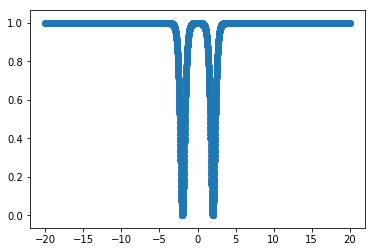

In [10]:
if uw.mpi.size == 1:   # Serial
    xx = np.arange(-20, 20, 0.01)
    yy = boundary(xx, minX, maxX, 10, 2)
    pyplot.scatter(xx,yy)

### Material distribution in the domain.




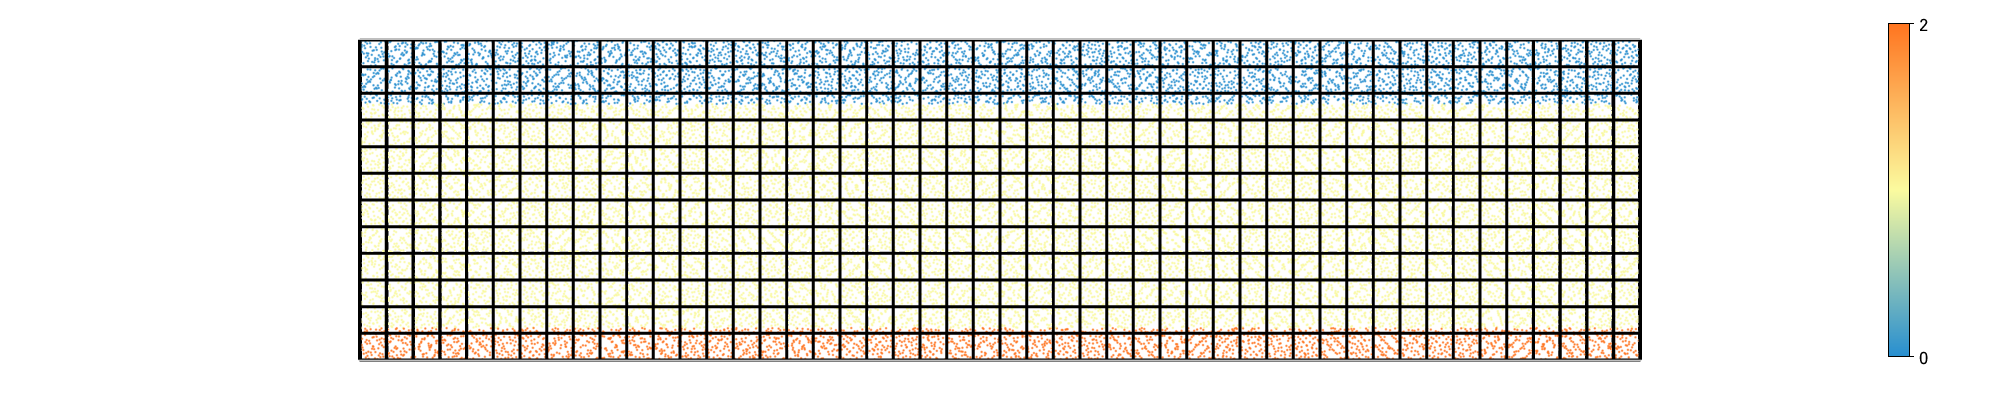

In [11]:
# Initialise the 'materialVariable' data to represent different materials. 
materialV = 1 # viscoplastic
materialA = 0 # accommodation layer a.k.a. Sticky Air
materialU = 2 # Under layer 

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.
coord = fn.input()

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.
conditions = [ (       coord[1] > 0.8 , materialA ),
               (       coord[1] < 0.1 , materialU ),
               (       True ,           materialV ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.
materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

# Viz configuration
figMaterials = vis.Figure(**viz_opts)
figMaterials.append(vis.objects.Points(swarm, fn_colour=materialVariable, fn_size=3))
figMaterials.append(vis.objects.Mesh(mesh))
figMaterials.show()

### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [12]:
# Interesting to test: very weak lower layer, very strong lower layer ... and something in the middle
viscosityA = 0.01
viscosityV = 1.0
viscosityU = 0.1  


viscosityMap = { materialA: viscosityA, materialV:viscosityV, materialU:viscosityU }

backgroundViscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = viscosityMap )

### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}



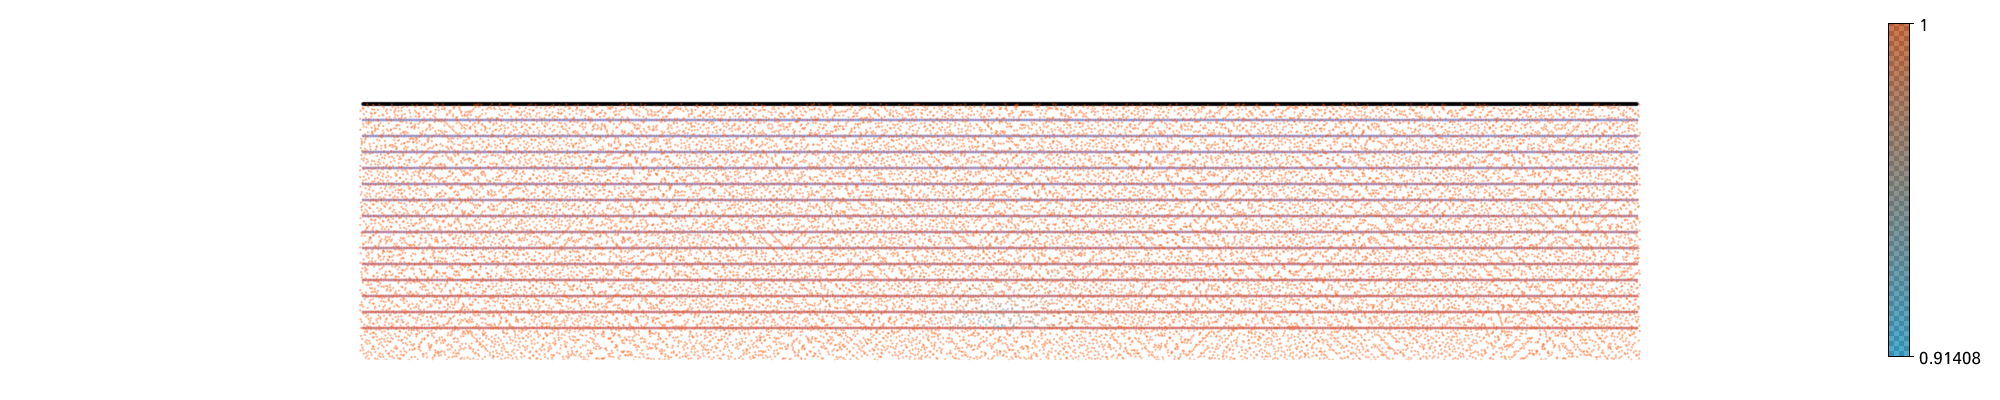

In [13]:
# Friction - in this form it could also be made to weaken with strain
frictionInf     = fn.misc.constant(0.3)
frictionFn      = frictionInf 

# Cohesion - a function of swarm variables
cohesionInfMap = { materialA: 1000.0, materialV:0.25, materialU:1000.0 }
cohesionInf     =  fn.branching.map( fn_key = materialVariable, 
                                     mapping = cohesionInfMap )

cohesion0       = fn.misc.constant(0.75)
referenceStrain = fn.misc.constant(0.5)

cohesionFn =  cohesionInf + cohesion0 * fn.math.exp(-plasticStrain / referenceStrain )

# Drucker-Prager yield criterion
yieldStressFn   = cohesionFn + frictionFn * pressureField

# Plot it and see (it will be the cohesion in the first run through) 
figYieldStress = vis.Figure(**viz_opts)
figYieldStress.append( vis.objects.Points(swarm, fn.misc.max(0.0,fn.misc.min(yieldStressFn, 1.0)) , pointSize=3.0, fn_mask=materialVariable, 
                                                      colours="#00BBFF:0.5 #FF5500:0.5") )
figYieldStress.append( vis.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000:0.9 #440000:0.9", colourBar=False) )
figYieldStress.append( vis.objects.Points(deformationSwarm, deformationVariable, pointSize=4.0, colourBar=False,
                                               colours="#BB4444:0.75 #6666BB:0.75") )

figYieldStress.show()

### Define composite (yielding) rheology

The actual constitutive behaviour is a composite of the behaviour below the yield strength and the reduced viscosity required to ensure that the stress remains bounded by the yield envelope.

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau _ \textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}

**Note**: The $1.0^{-18}$ added to the strain-rate is supposed to be a small number preventing the rheology from blowing up if the velocity field is zero. Obviously this number should be much smaller than the expected strain rate !

In [14]:
# first define strain rate tensor
strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding
min_viscosity = viscosityA  # same as the air ... 

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
                                                              backgroundViscosityFn), 
                                                  min_viscosity))

### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

In [15]:
devStressFn = 2.0 * viscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [16]:
densityMap = { materialA: 0.0, materialV:1.0, materialU:10.0 }

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap )

# And the final buoyancy force function.
z_hat = ( 0.0, 1.0 )
buoyancyFn = -densityFn * z_hat

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [17]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = velocityBCs,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Define a function to perform pressure calibration. 
# It will be used as a callback during non-linear 
# iteration to ensure pressure is calibrated per
# iteration.
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
def calibrate_pressure():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

nl_tol = 1.e-2
solver.solve( nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure )
solver.print_stats()


 
Pressure iterations:  12
Velocity iterations:   6 (presolve)      
Velocity iterations:  87 (pressure solve)
Velocity iterations:   5 (backsolve)     
Velocity iterations:  98 (total solve)   
 
SCR RHS  setup time: 5.3653e-03
SCR RHS  solve time: 9.4970e-03
Pressure setup time: 1.5734e-04
Pressure solve time: 9.3357e-02
Velocity setup time: 7.3297e-07 (backsolve)
Velocity solve time: 5.6888e-03 (backsolve)
Total solve time   : 1.2474e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




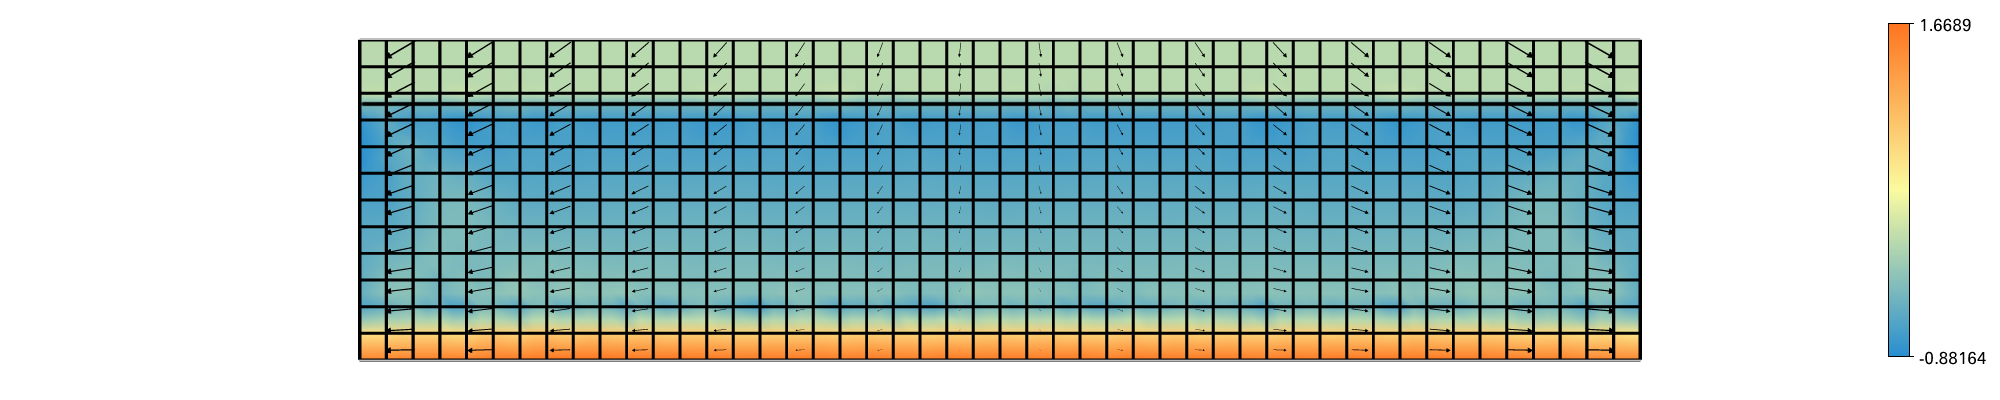

In [18]:
figVelocityPressure = vis.Figure(**viz_opts)
figVelocityPressure.append( vis.objects.VectorArrows(mesh, velocityField, scaling=.1) )
figVelocityPressure.append( vis.objects.Surface(mesh, pressureField) )
figVelocityPressure.append( vis.objects.Points(surfaceSwarm, pointSize=5.0, colourBar=False, colours="#440000 #440000") )
figVelocityPressure.append( vis.objects.Mesh(mesh))
figVelocityPressure.show()


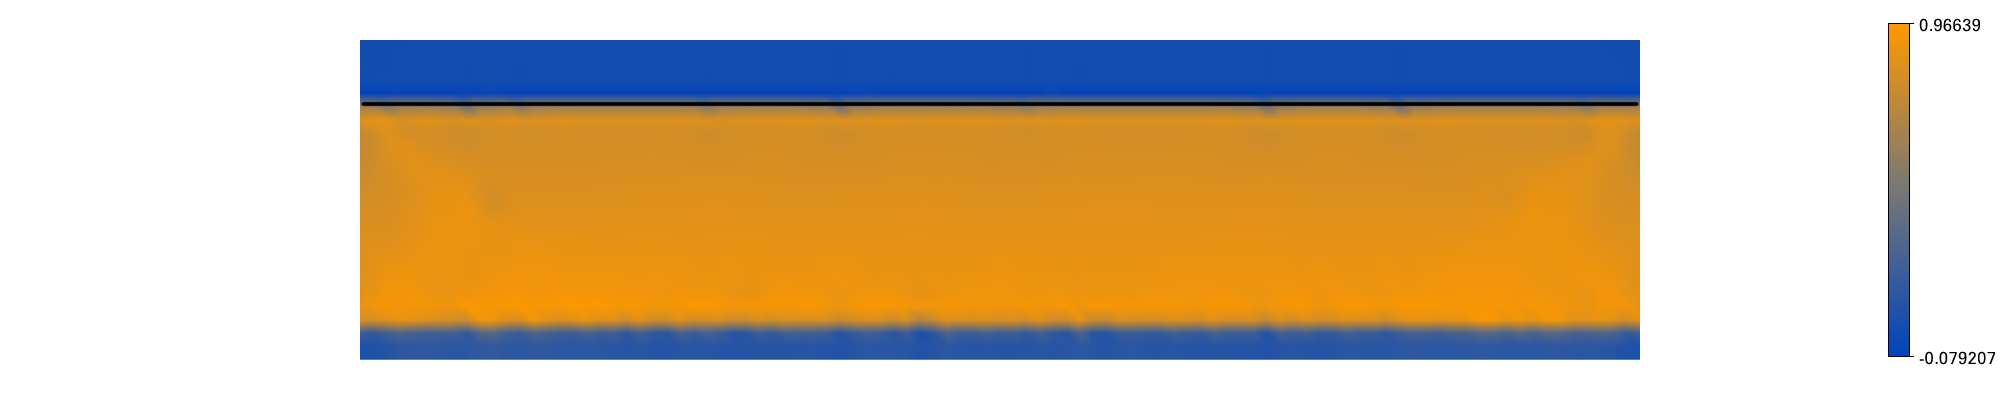

In [19]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help
meshDevStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

figMeshStress = vis.Figure(**viz_opts)
figMeshStress.append( vis.objects.Surface(mesh, meshDevStress  , colours="#0044BB, #777777, #FF9900") )
figMeshStress.append( vis.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000 #440000", colourBar=False) )

figMeshStress.show()


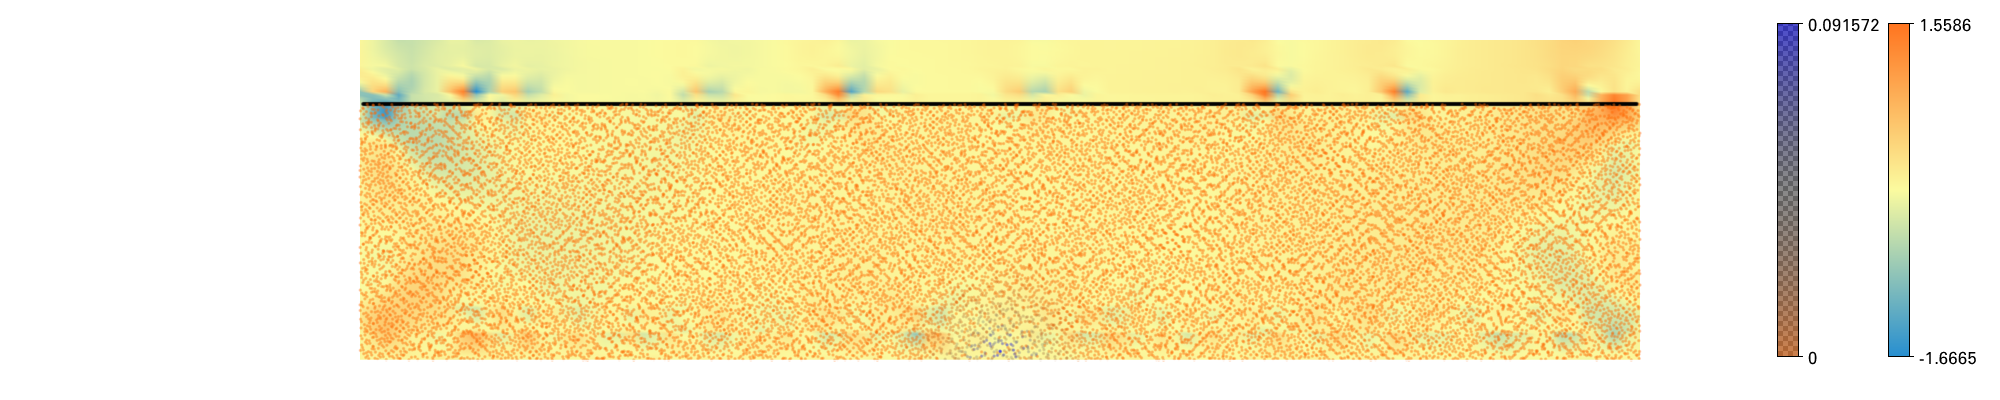

In [20]:
curlV = velocityField.fn_gradient[1] - velocityField.fn_gradient[2]
figStrain = vis.Figure(**viz_opts)
figStrain.append( vis.objects.Surface(mesh, curlV, onMesh=False) )
figStrain.append( vis.objects.Points(swarm, plasticStrain, pointSize=4.0, 
                  fn_mask=materialVariable,  colours="#FF6600:0.5, #555555:0.25, Blue:0.5") )
figStrain.append( vis.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000 #440000", colourBar=False) )


figStrain.show()

## Main simulation loop

In [21]:
# create an array which will be used to advect/update the mesh
mesh_vels = meshV*np.copy(mesh.data[:,0])/maxX
# also create projection object
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )

In [22]:
def update():
    # get timestep and advect particles
    dt = advector.get_max_dt()
    advector.integrate(dt, update_owners=False)
    advector2.integrate(dt, update_owners=False)
    advector3.integrate(dt, update_owners=False)
    
    # Stretch mesh to match boundary conditions
    # Note that this also calls the update_particle_owners for the
    # attached swarms
    with mesh.deform_mesh( isRegular=True ):
        mesh.data[:,0] += mesh_vels[:]*dt

    newtime = time + dt
    # recalc mesh exten
    newminX = minX - meshV * newtime
    newmaxX = maxX + meshV * newtime

    # particle population control
    pop_control.repopulate()
    
    # update stretching metric
    swarmVgrad = velocityField.fn_gradient.evaluate(swarm)
    stretching.data[:,0] += dt * (swarmVgrad[:,0] * stretching.data[:,0] + swarmVgrad[:,1] * stretching.data[:,1])
    stretching.data[:,1] += dt * (swarmVgrad[:,2] * stretching.data[:,0] + swarmVgrad[:,3] * stretching.data[:,1])

    # update plastic strain
    swarmYield = viscosityFn.evaluate(swarm) < backgroundViscosityFn.evaluate(swarm)
    swarmStrainRateInv = strainRate_2ndInvariantFn.evaluate(swarm)
    weight = boundary(swarm.particleCoordinates.data[:,0], newminX, newmaxX, 10.0, 2) 
    plasticStrainIncrement = dt * np.where(swarmYield, swarmStrainRateInv , 0.0 )
    plasticStrainIncrement[:,0] *= weight
    plasticStrain.data[:] += plasticStrainIncrement

    return newtime, step+1

In [23]:
# define a func to get the max plastic strain
minmax = fn.view.min_max(plasticStrain)
def get_max_plastic_strain():
    minmax.reset()
    minmax.evaluate(swarm)
    return minmax.max_global()

In [24]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 40

frictionValueAsString = str(frictionInf.evaluate([0.0,0.0])[0,0]) # For tagging in file names

while step<nsteps:
    # Obtain V,P 
    solver.solve( nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure )
    
    if (step%5 ==0):      
        figYieldStress.save_image(      outputPath + "figYield-" +frictionValueAsString+"-" + str(step).zfill(4))
        figVelocityPressure.save_image( outputPath + "figVP-"    +frictionValueAsString+"-" + str(step).zfill(4))
        projectorStress.solve()
        figStrain.save_image(           outputPath + "figStrain-"+frictionValueAsString+"-" + str(step).zfill(4))
    
    # Get global metrics.
    # Note that to avoid a deadlock when running in parallel,
    # both of these functions need to be called collectively 
    # by all processes, not just by rank==0. 
    max_pstrain = get_max_plastic_strain()
    vrms = stokes.velocity_rms()
    if uw.mpi.rank==0:   
        print('step = {0:4d};  time = {1:.3e};  vrms = {2:.3e};  max_pstrain = {3:.3e}'.format(step,time,vrms,max_pstrain))
    
    # finished timestep, update all
    time, step = update()

step =    0;  time = 0.000e+00;  vrms = 6.368e-01;  max_pstrain = 9.157e-02
step =    1;  time = 1.814e-02;  vrms = 6.390e-01;  max_pstrain = 9.157e-02
step =    2;  time = 3.645e-02;  vrms = 6.417e-01;  max_pstrain = 9.157e-02
step =    3;  time = 5.492e-02;  vrms = 6.452e-01;  max_pstrain = 9.157e-02
step =    4;  time = 7.360e-02;  vrms = 6.481e-01;  max_pstrain = 9.892e-02
step =    5;  time = 9.240e-02;  vrms = 6.508e-01;  max_pstrain = 1.084e-01
step =    6;  time = 1.114e-01;  vrms = 6.527e-01;  max_pstrain = 1.180e-01
step =    7;  time = 1.305e-01;  vrms = 6.545e-01;  max_pstrain = 1.280e-01
step =    8;  time = 1.498e-01;  vrms = 6.557e-01;  max_pstrain = 1.386e-01
step =    9;  time = 1.691e-01;  vrms = 6.568e-01;  max_pstrain = 1.506e-01
step =   10;  time = 1.884e-01;  vrms = 6.579e-01;  max_pstrain = 1.637e-01
step =   11;  time = 2.078e-01;  vrms = 6.581e-01;  max_pstrain = 1.781e-01
step =   12;  time = 2.272e-01;  vrms = 6.589e-01;  max_pstrain = 1.930e-01
step =   13;

Post simulation analysis
-----


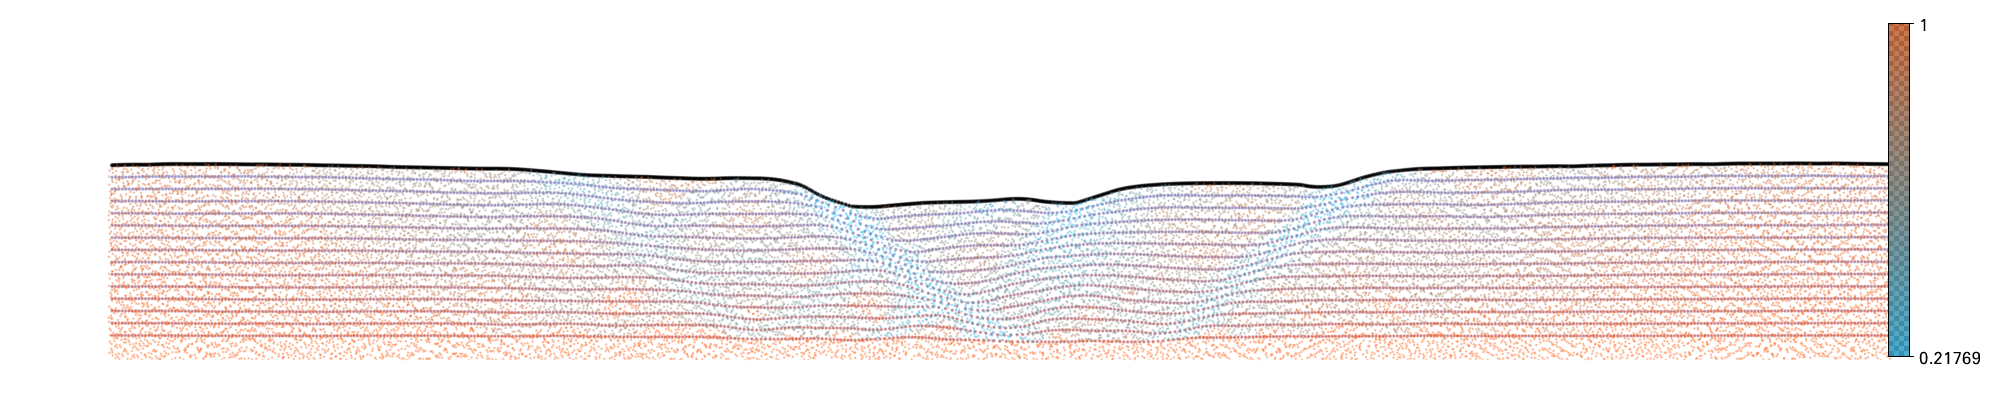

In [25]:
figYieldStress.show()


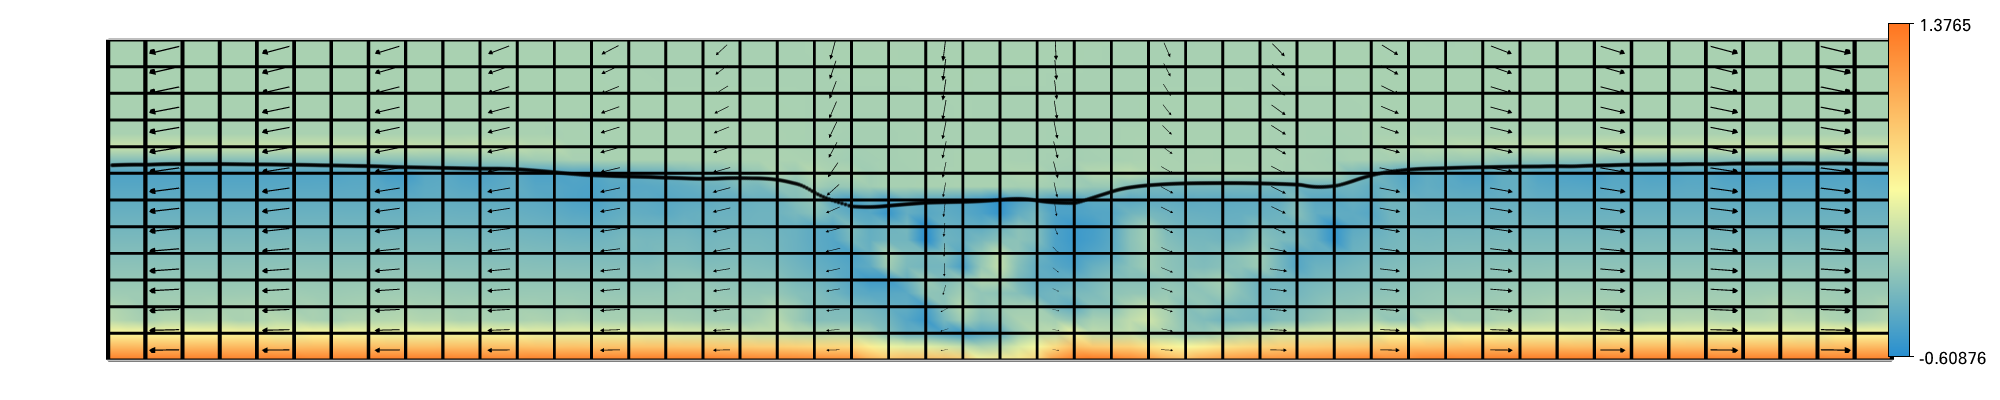

In [26]:
figVelocityPressure.show()


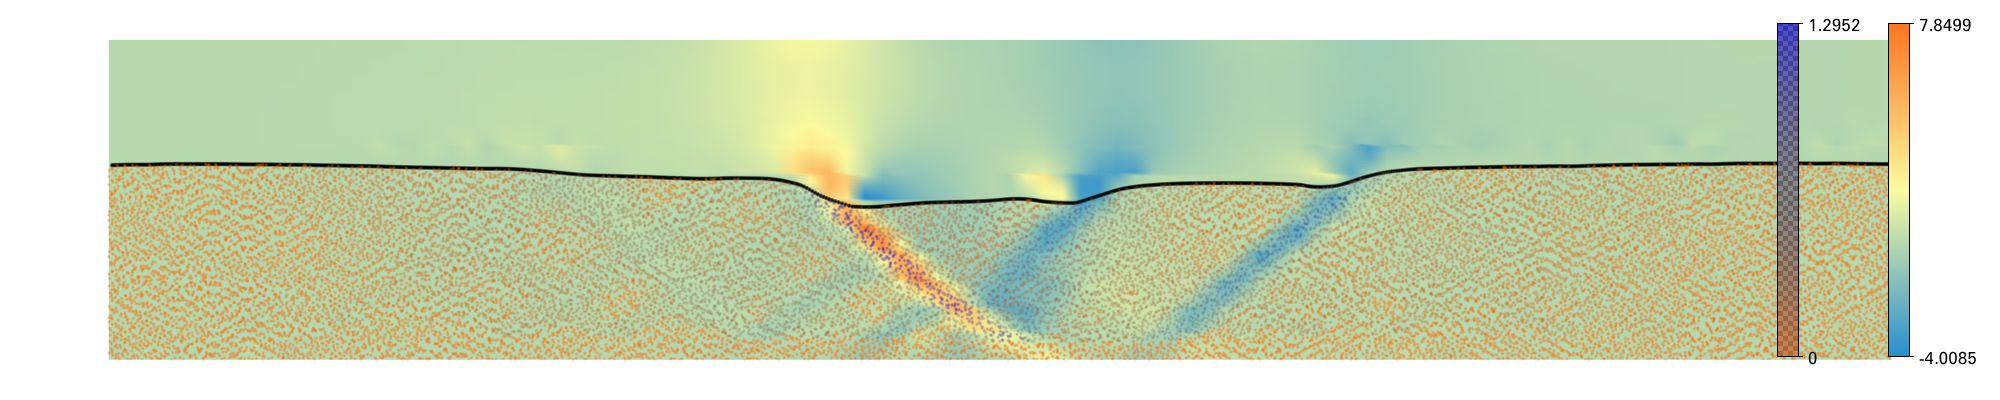

In [27]:
figStrain.show()


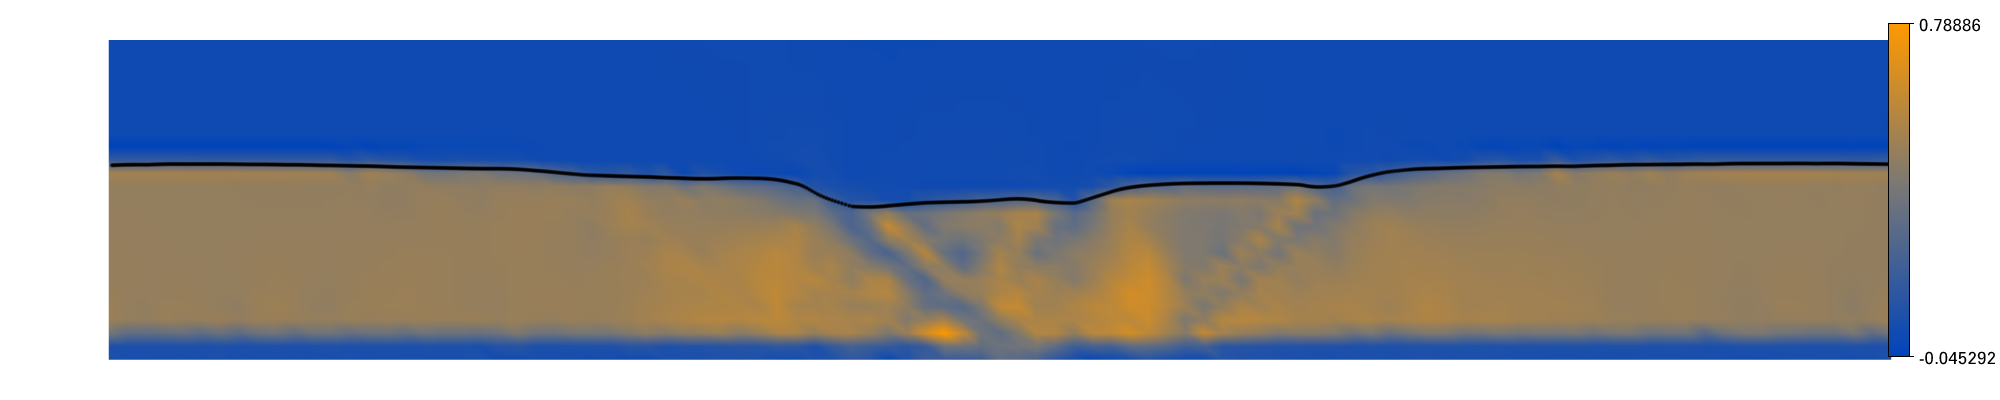

In [28]:
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

figMeshStress.show()

### Particle shear-strain measure



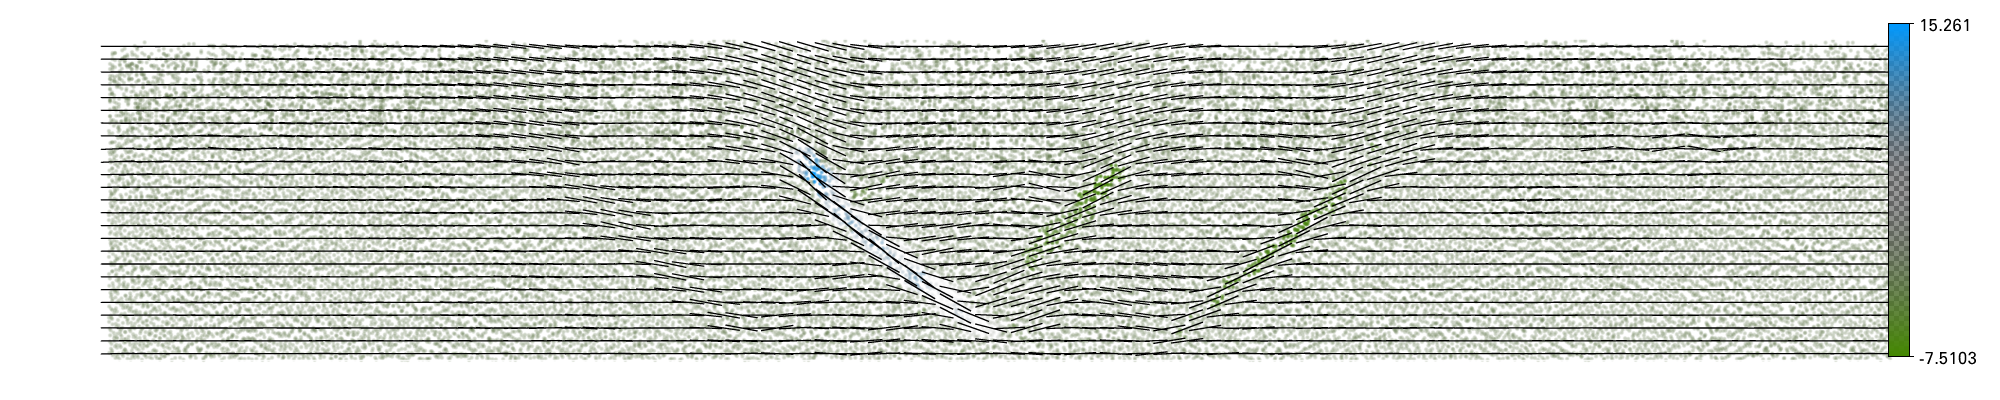

In [29]:
swarmVgrad = velocityField.fn_gradient.evaluate(swarm)

meshStretching = mesh.add_variable( 2 )

orientation.data[:,0] = np.where( np.abs(swarmVgrad[:,0]) > 1.1, -180 * np.arctan2(stretching.data[:,1] / math.pi, stretching.data[:,0]) / math.pi, 0.0)

projectStretching = uw.utils.MeshVariable_Projection( meshStretching, stretching, type=0 )
projectStretching.solve()
meshStretching.data[:,0] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )
meshStretching.data[:,1] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )


figMeshStretching = vis.Figure(**viz_opts)
figMeshStretching.append( vis.objects.VectorArrows(mesh, meshStretching, scaling=0.1, arrowHead=0.00001, resolution=[100,25,1])) 
figMeshStretching.append( vis.objects.Points(swarm, orientation , pointSize=5.0, colours="#448800, #666666:0.0, #0099FF") )
figMeshStretching.show()



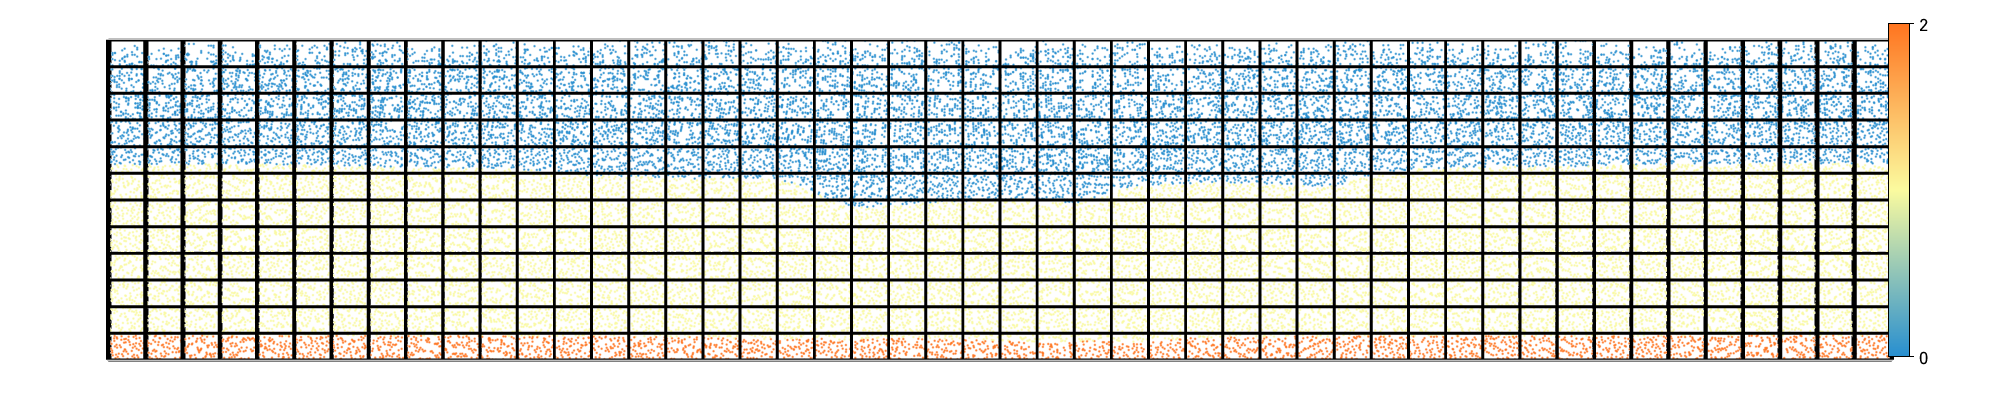

In [30]:
figMaterials.show()

In [31]:
# Add some tests to anchor results to expected values. 
# Note that these tests are only valid for the standard
# model parameters. Also, note that while the result 
# here are consistent with the results obtained by the 
# original version of this notebook, a more rigorous review
# is warranted to establish numerical and mathematical accuracy.
vrms_obtained = stokes.velocity_rms()
vrms_expected = 0.7101
if not np.isclose(vrms_obtained,vrms_expected,rtol=1e-4):
    raise RuntimeError("VRMS value ({}) differs from expected value ({}).".format(vrms_obtained,vrms_expected))